In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv1D, Input
from tensorflow.python.keras import regularizers
from keras.models import Model

In [2]:
frauds = pd.read_csv('data/frauds.csv')
nonfrauds = pd.read_csv('data/nonfrauds.csv')

In [6]:
frauds['is_fraud'] = 1
nonfrauds['is_fraud'] = 0

In [7]:
df = frauds.append([nonfrauds])

In [17]:
df

,key,user_transaction_time,channel,transaction_risk_score,processing_type,cc_amount,ledger_balance,cc_acceptor_state,acceptor_state,cardholder_presence,card_presence,is_fraud
0,9d851f1b-00b3-4b02-9494-beda8866d6f7,2020-12-29T16:13:49Z,ECOMMERCE,82.0,MANUAL,14.99,134.91,NaN,NaN,0.0,0.0,1
1,dc13ebc6-a527-46d0-b424-6642d47c8a11,2020-12-29T16:13:32Z,ECOMMERCE,82.0,MANUAL,14.99,359.76,NaN,NaN,0.0,0.0,1
2,5e8f4d8f-a720-4a3d-ac55-f8953db3b527,2020-12-29T16:13:13Z,ECOMMERCE,82.0,MANUAL,14.99,419.72,NaN,NaN,0.0,0.0,1
3,74e6ff6d-f341-4300-8cac-30ab9e5ed5cf,2020-12-29T16:12:56Z,ECOMMERCE,82.0,MANUAL,14.99,149.90,NaN,NaN,0.0,0.0,1
4,c63d2508-f935-4092-bde1-434e1acbd0ef,2020-12-29T16:12:38Z,ECOMMERCE,82.0,MANUAL,14.99,164.89,NaN,NaN,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
40889,e50cadff-4009-4fd4-ae84-b59f8b831c19,2022-02-22T20:29:29Z,OTHER,8.0,CHIP,19.70,52.00,FL,12.0,1.0,1.0,0
40890,69152019-8359-4484-a30a-bc9219050fa8,2022-02-22T20:29:08Z,MOTO,4.0,CARD_ON_FILE,422.43,1552.61,CA,6.0,0.0,0.0,0
40891,fd7902a2-50bc-4698-9c95-9b7a1be10ef4,2022-02-22T20:28:22Z,ECOMMERCE,2.0,MANUAL,5.57,57.98,WY,56.0,0.0,0.0,0
40892,7e876176-d505-45a3-8537-caa30c5f2909,2022-02-22T20:28:18Z,ECOMMERCE,4.0,MANUAL,18.83,1954.10,WA,53.0,0.0,0.0,0


In [16]:
df.is_fraud.value_counts()

0    40894
1      398
Name: is_fraud, dtype: int64

In [326]:
40894/41292 * 100

99.03613290710065

In [20]:
df['transaction_risk_score'] = df['transaction_risk_score'].fillna('0')

In [31]:
df2 = df[['transaction_risk_score','cc_amount','is_fraud']]

In [165]:
X = df2[['transaction_risk_score','cc_amount']]
x = df2['transaction_risk_score']
Y = df2['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

scalar = StandardScaler()
x_train_scale = scalar.fit_transform(X_train)
x_test_scale = scalar.transform(X_test)

x_norm_test, x_fraud_test = x_test_scale[y_test == 0], x_test_scale[y_test == 1]

Text(0, 0.5, 'is_fraud')

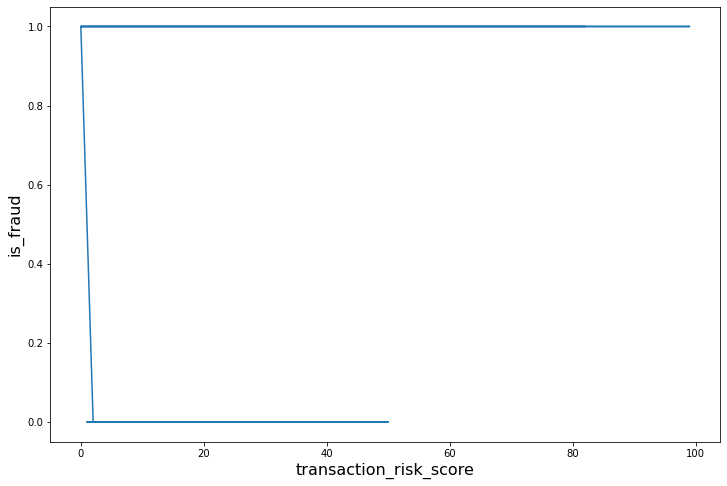

In [305]:
plt.figure(figsize=(12,8))
plt.plot(x,Y)
plt.xlabel(r'transaction_risk_score', fontsize=16)
plt.ylabel(r'is_fraud', fontsize=16)

In [167]:
reg = LogisticRegression()
reg.fit(x_train_scale,y_train)
reg_pred = reg.predict(x_test_scale)
print(classification_report(y_test,reg_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12257
           1       0.96      0.61      0.75       131

    accuracy                           1.00     12388
   macro avg       0.98      0.81      0.87     12388
weighted avg       1.00      1.00      1.00     12388



In [168]:
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(x_train_scale,y_train)
pred = clf.predict(x_test_scale)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12257
           1       0.98      0.62      0.76       131

    accuracy                           1.00     12388
   macro avg       0.99      0.81      0.88     12388
weighted avg       1.00      1.00      1.00     12388



In [227]:
from tensorflow.keras.optimizers import SGD

metrics = [
    'accuracy',
    keras.metrics.Precision(),
    keras.metrics.Recall()
]

epochs=50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
input_dim = x_train_scale.shape[1]

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

def NN(Xt):
    model = keras.Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer = sgd, 
                  loss = 'binary_crossentropy', metrics = metrics)
    
    return model

In [229]:
model = NN(Xt = x_train_scale)
lr_model_history = model.fit(x_train_scale, y_train, validation_data = (x_test_scale, y_test), 
                             batch_size = 32, epochs = epochs, verbose = 1)

Epoch 1/50
904/904 [==============================] - 2s 2ms/step - loss: 0.0581 - accuracy: 0.9910 - precision_24: 0.7000 - recall_24: 0.2421 - val_loss: 0.0213 - val_accuracy: 0.9952 - val_precision_24: 0.9863 - val_recall_24: 0.5496
Epoch 2/50
904/904 [==============================] - 2s 2ms/step - loss: 0.0261 - accuracy: 0.9937 - precision_24: 0.8696 - recall_24: 0.3745 - val_loss: 0.0212 - val_accuracy: 0.9950 - val_precision_24: 0.9859 - val_recall_24: 0.5344
Epoch 3/50
904/904 [==============================] - 2s 3ms/step - loss: 0.0246 - accuracy: 0.9942 - precision_24: 0.9224 - recall_24: 0.4007 - val_loss: 0.0196 - val_accuracy: 0.9956 - val_precision_24: 0.9872 - val_recall_24: 0.5878
Epoch 4/50
904/904 [==============================] - 4s 5ms/step - loss: 0.0243 - accuracy: 0.9947 - precision_24: 0.9453 - recall_24: 0.4532 - val_loss: 0.0197 - val_accuracy: 0.9954 - val_precision_24: 0.9744 - val_recall_24: 0.5802
Epoch 5/50
904/904 [==============================] - 4s

904/904 [==============================] - 6s 6ms/step - loss: 0.0209 - accuracy: 0.9956 - precision_24: 0.9669 - recall_24: 0.5468 - val_loss: 0.0191 - val_accuracy: 0.9958 - val_precision_24: 0.9877 - val_recall_24: 0.6107
Epoch 36/50
904/904 [==============================] - 6s 6ms/step - loss: 0.0206 - accuracy: 0.9955 - precision_24: 0.9419 - recall_24: 0.5468 - val_loss: 0.0191 - val_accuracy: 0.9958 - val_precision_24: 0.9877 - val_recall_24: 0.6107
Epoch 37/50
904/904 [==============================] - 5s 6ms/step - loss: 0.0204 - accuracy: 0.9956 - precision_24: 0.9603 - recall_24: 0.5431 - val_loss: 0.0191 - val_accuracy: 0.9958 - val_precision_24: 0.9877 - val_recall_24: 0.6107 loss: 0.0216 - accuracy: 0.9953 - precision
Epoch 38/50
904/904 [==============================] - 5s 5ms/step - loss: 0.0206 - accuracy: 0.9956 - precision_24: 0.9664 - recall_24: 0.5393 - val_loss: 0.0190 - val_accuracy: 0.9958 - val_precision_24: 0.9877 - val_recall_24: 0.6107
Epoch 39/50
904/904 

In [230]:
print('accuracy: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[1]))
print('precision: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[2]))
print('recall: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[3]))

accuracy: 0.9958024024963379
precision: 0.9876543283462524
recall: 0.6106870174407959


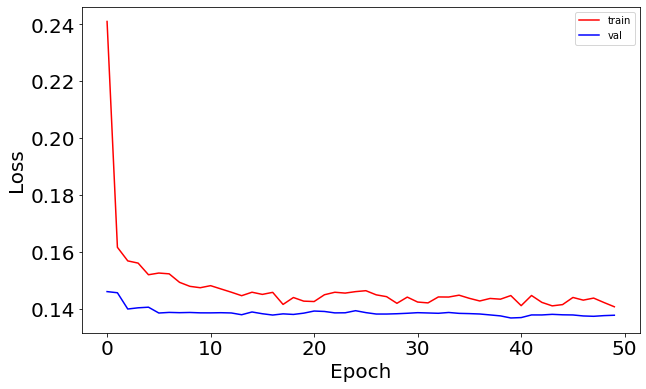

In [231]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

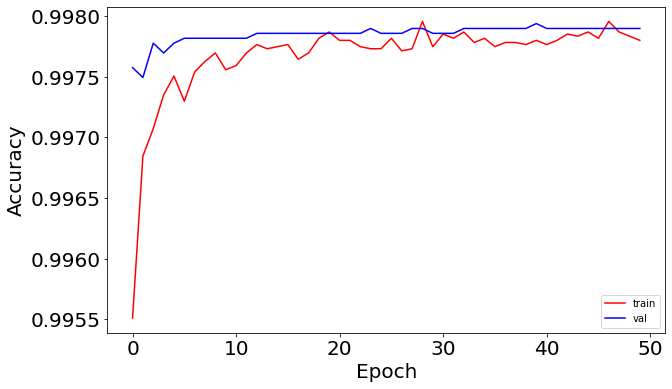

In [232]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [233]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

epochs = 50
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

# learning schedule callback
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [lr_rate]

In [241]:
exp_model = NN(Xt = x_train_scale)
exponential_decay_model_history = exp_model.fit(x_train_scale, y_train,
                                    batch_size=64,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data=(x_test_scale, y_test))

Epoch 1/50
452/452 [==============================] - 2s 2ms/step - loss: 0.8060 - accuracy: 0.1733 - precision_24: 0.0140 - recall_24: 0.6616 - val_loss: 0.7451 - val_accuracy: 0.3508 - val_precision_24: 0.0156 - val_recall_24: 0.9695 - lr: 0.1000
Epoch 2/50
452/452 [==============================] - 1s 2ms/step - loss: 0.7862 - accuracy: 0.2899 - precision_24: 0.0120 - recall_24: 0.9363 - val_loss: 0.7257 - val_accuracy: 0.7408 - val_precision_24: 0.0378 - val_recall_24: 0.9618 - lr: 0.0905
Epoch 3/50
452/452 [==============================] - 1s 2ms/step - loss: 0.7677 - accuracy: 0.4067 - precision_24: 0.0140 - recall_24: 0.9101 - val_loss: 0.7093 - val_accuracy: 0.7661 - val_precision_24: 0.0414 - val_recall_24: 0.9542 - lr: 0.0819
Epoch 4/50
452/452 [==============================] - 1s 2ms/step - loss: 0.7535 - accuracy: 0.5061 - precision_24: 0.0164 - recall_24: 0.8876 - val_loss: 0.6955 - val_accuracy: 0.7846 - val_precision_24: 0.0449 - val_recall_24: 0.9542 - lr: 0.0741
Epoc

452/452 [==============================] - 1s 2ms/step - loss: 0.6411 - accuracy: 0.8715 - precision_24: 0.0554 - recall_24: 0.8052 - val_loss: 0.5981 - val_accuracy: 0.9140 - val_precision_24: 0.1022 - val_recall_24: 0.9160 - lr: 0.0041
Epoch 34/50
452/452 [==============================] - 1s 2ms/step - loss: 0.6417 - accuracy: 0.8708 - precision_24: 0.0536 - recall_24: 0.7790 - val_loss: 0.5976 - val_accuracy: 0.9143 - val_precision_24: 0.1025 - val_recall_24: 0.9160 - lr: 0.0037
Epoch 35/50
452/452 [==============================] - 1s 2ms/step - loss: 0.6390 - accuracy: 0.8705 - precision_24: 0.0548 - recall_24: 0.8015 - val_loss: 0.5972 - val_accuracy: 0.9144 - val_precision_24: 0.1027 - val_recall_24: 0.9160 - lr: 0.0033
Epoch 36/50
452/452 [==============================] - 1s 2ms/step - loss: 0.6410 - accuracy: 0.8713 - precision_24: 0.0542 - recall_24: 0.7865 - val_loss: 0.5969 - val_accuracy: 0.9146 - val_precision_24: 0.1028 - val_recall_24: 0.9160 - lr: 0.0030
Epoch 37/50


Text(0, 0.5, 'Learning rate')

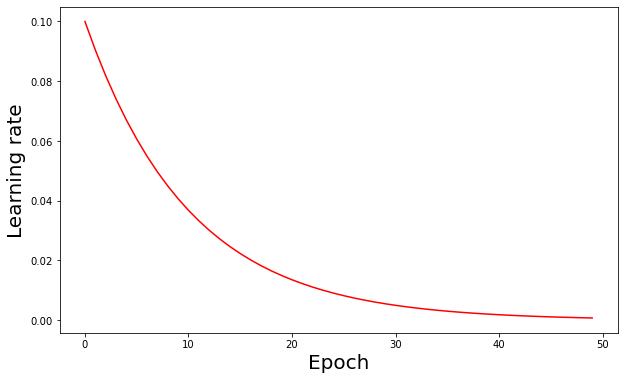

In [312]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(exponential_decay_model_history.history['lr'], 'r')
ax.set_xlabel(r'Epoch', fontsize=20)zs
ax.set_ylabel(r'Learning rate', fontsize=20)

In [242]:
print('accuracy: ' + str(exp_model.evaluate(x_test_scale,y_test, verbose=0)[1]))
print('precision: ' + str(exp_model.evaluate(x_test_scale,y_test, verbose=0)[2]))
print('recall: ' + str(exp_model.evaluate(x_test_scale,y_test, verbose=0)[3]))

accuracy: 0.9198417663574219
precision: 0.10818181931972504
recall: 0.9083969593048096


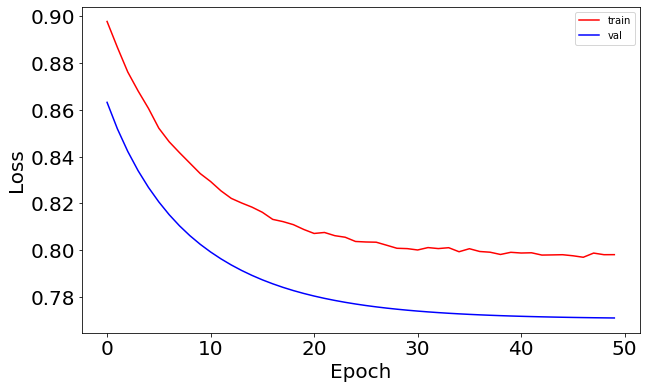

In [243]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

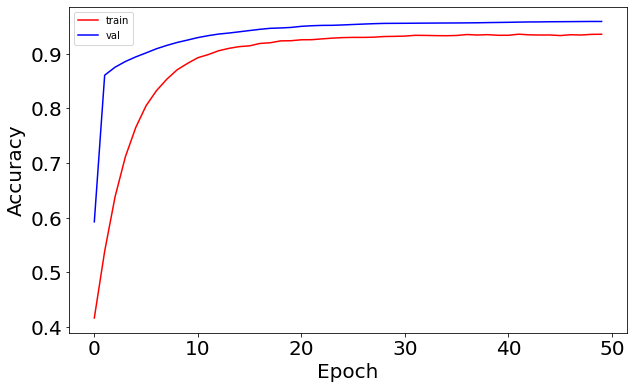

In [314]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)